#### Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from skimage import img_as_ubyte
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
import os
import pickle

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Select data again

In [4]:
new_df=pd.read_pickle('/content/drive/MyDrive/Capstone_programming/wafer_map_new.pkl')
new_df

,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,"(45, 48)"
...,...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,[[Test]],[[Edge-Loc]],2,"(26, 30)"
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],2,"(26, 30)"
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],3,"(26, 30)"
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],2,"(26, 30)"


In [5]:
# Drop fault data
index_fault = []
for i in range(len(new_df)):
  if np.size(new_df.waferMap[i],axis=1)< 5 or np.size(new_df.waferMap[i],axis=0)< 5:
    index_fault.append(new_df.index[i])

In [6]:
new_df=new_df.drop(index_fault,axis=0)

In [7]:
faulty_wafer=np.unique(new_df['failureNum'])
for f in faulty_wafer :
    print('{} : {}'.format(f, len(new_df[new_df['failureNum']==f])))

0 : 4294
1 : 555
2 : 5189
3 : 9680
4 : 3593
5 : 866
6 : 1193
7 : 149
8 : 147429


In [8]:
def select_data(failure_num,number_sample ):
  wafer = []
  label = []
  index_class = np.array(new_df[new_df['failureNum'] == failure_num].index)
  for i in range(number_sample):
    k = index_class[i]
    wafer.append(cv2.resize(new_df['waferMap'][k], (56,56), interpolation=cv2.INTER_NEAREST ))
    label.append(failure_num)
  return np.array(wafer), np.array(label)

In [9]:
#Select only rate% of raw data
rate = 0.5
center_wm, center_label = select_data(0, round(len(new_df[new_df['failureNum']==0])*rate))
donut_wm, donut_label = select_data(1, round(len(new_df[new_df['failureNum']==1])*rate))
edgloc_wm, edgloc_label = select_data(2, round(len(new_df[new_df['failureNum']==2])*rate))
edgring_wm, edgring_label = select_data(3, round(len(new_df[new_df['failureNum']==3])*rate))
loc_wm, loc_label = select_data(4, round(len(new_df[new_df['failureNum']==4])*rate))
random_wm, random_label = select_data(5, round(len(new_df[new_df['failureNum']==5])*rate))
scratch_wm, scratch_label = select_data(6, round(len(new_df[new_df['failureNum']==6])*rate))
nearfull_wm, nearfull_label = select_data(7, round(len(new_df[new_df['failureNum']==7])*rate))
none_wm, none_label = select_data(8, round(len(new_df[new_df['failureNum']==8])*rate))

In [24]:
# collect the whole data
# new_df = new_df.reset_index()
wafer = []
label = []
for i in range(len(new_df)):
    wafer.append(cv2.resize(new_df['waferMap'][i], (56,56), interpolation=cv2.INTER_NEAREST ))
    label.append(new_df['failureNum'][i])
wafer = np.array(wafer)
label = np.array(label)

In [12]:
wafer = np.concatenate((center_wm, donut_wm, edgloc_wm, edgring_wm, loc_wm, random_wm, scratch_wm, nearfull_wm, none_wm))

In [13]:
label = np.concatenate((center_label, donut_label, edgloc_label, edgring_label, loc_label, random_label, scratch_label, nearfull_label, none_label  ))

In [25]:
wafer.shape, label.shape

((172948, 56, 56), (172948,))

# Save data function

In [26]:
save_path = '/content/drive/MyDrive/Thesis_programming/Dataset_2C_0.5/'

In [27]:
def save_data(save_object, save_path, filename):
  save_file = save_path + filename + '.pkl'
  with open(save_file, 'wb') as f:
    pickle.dump(save_object, f)

In [28]:
save_data(wafer, save_path, 'wafer_map_0.5rate' )
save_data(label, save_path, 'wafer_label_0.5rate' )

#Train_test_valid split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, X_test, y_train, Y_test = train_test_split(wafer, label, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [31]:
print('x_train: ', X_train.shape)
print('x_test: ',X_test.shape)
print('x_val: ',X_val.shape)
print('y_train: ',Y_train.shape)
print('y_test: ', Y_test.shape)
print('y_test: ', Y_val.shape)

x_train:  (110686, 56, 56)
x_test:  (34590, 56, 56)
x_val:  (27672, 56, 56)
y_train:  (110686,)
y_test:  (34590,)
y_test:  (27672,)


In [32]:
for f in faulty_wafer :
    print('{} : {}'.format(f, len(Y_train[Y_train == f])))

0 : 2711
1 : 366
2 : 3349
3 : 6268
4 : 2299
5 : 570
6 : 738
7 : 104
8 : 94281


In [33]:
for f in faulty_wafer :
    print('{} : {}'.format(f, len(Y_test[Y_test == f])))

0 : 867
1 : 101
2 : 998
3 : 1874
4 : 715
5 : 160
6 : 267
7 : 24
8 : 29584


In [34]:
for f in faulty_wafer :
    print('{} : {}'.format(f, len(Y_val[Y_val == f])))

0 : 716
1 : 88
2 : 842
3 : 1538
4 : 579
5 : 136
6 : 188
7 : 21
8 : 23564


## Save data

In [35]:
save_data(X_train, save_path, 'wafer_map_train_0.5')

In [36]:
save_data(X_test, save_path, 'wafer_map_test_0.5')
save_data(X_val, save_path, 'wafer_map_val_0.5')
save_data(Y_train, save_path, 'wafer_label_train_0.5')
save_data(Y_test, save_path, 'wafer_label_test_0.5')
save_data(Y_val, save_path, 'wafer_label_val_0.5')

# Convert to 3 channels

#### Function

In [ ]:
def convert_to_RGB(wafer):
  wafer_map_RGB = np.zeros((len(wafer), 56, 56, 3))
  for w in range(len(wafer)):
     for i in range(56):
        for j in range(56):
            wafer_map_RGB[w, i, j, int(wafer[w, i, j])] = 1
  return wafer_map_RGB

In [ ]:
wafer_RGB  = convert_to_RGB(wafer)

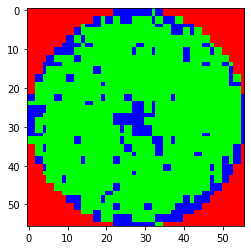

In [ ]:
plt.imshow(wafer_RGB[1039])

#### Implement

In [ ]:
#Val_set
X_val_rgb = convert_to_RGB(X_val)

In [ ]:
#Test_set
X_test_rgb = convert_to_RGB(X_test)

**Import X_train, Y_train**

In [ ]:
X_train = pd.read_pickle('/content/drive/MyDrive/Thesis_programming/General_data/wafermap_train.pkl')

In [ ]:
Y_train = pd.read_pickle('/content/drive/MyDrive/Thesis_programming/General_data/wafer_label_train.pkl')

In [ ]:
X_train.shape, Y_train.shape

((11068, 227, 227), (11068,))

In [ ]:
#Train_set
X_train_rgb = convert_to_RGB(X_train)

In [ ]:
#Only class 8
X_train_class8 = X_train[Y_train == 8]
X_train_class8_rgb = convert_to_RGB(X_train_class8)

# Convert array to image

#### Function

In [ ]:
def save_image(data,label,directory,phase):
  for i in range(len(data)):
      # img = Image.fromarray(img_as_ubyte(data[i]),'RGB')
      img = Image.fromarray(img_as_ubyte(data[i]))
      image_path = (directory + phase + '/' + label +'/'+ 'wm_' + label + '_' + str(i) + '.png')
      img.save(image_path)

In [ ]:
def divide_data(data,label,number): 
  data = data[label == number]
  return data

In [ ]:
a = img_as_ubyte(wafer[0])

In [ ]:
img = Image.fromarray(a,mode='L')

In [ ]:
img.save(image_path)

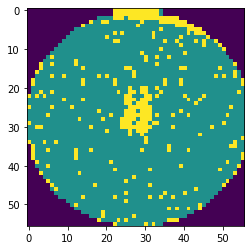

In [ ]:
plt.imshow(array)

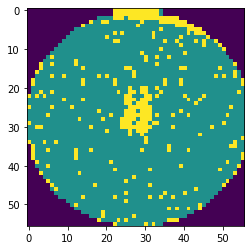

In [ ]:
plt.imshow(wafer[0])

#### Implement

In [ ]:
directory = '/content/drive/MyDrive/Thesis_programming/Dataset/'

##### Valid data

In [ ]:
# Class_0_val = divide_data(X_val_rgb, Y_val, 0)
Class_0_val = divide_data(X_val, Y_val, 0)

In [ ]:
# Class_1_val = divide_data(X_val_rgb, Y_val, 1)
# Class_2_val = divide_data(X_val_rgb, Y_val, 2)
# Class_3_val = divide_data(X_val_rgb, Y_val, 3)
# Class_4_val = divide_data(X_val_rgb, Y_val, 4)
# Class_5_val = divide_data(X_val_rgb, Y_val, 5)
# Class_6_val = divide_data(X_val_rgb, Y_val, 6)
# Class_7_val = divide_data(X_val_rgb, Y_val, 7)

Class_1_val = divide_data(X_val, Y_val, 1)
Class_2_val = divide_data(X_val, Y_val, 2)
Class_3_val = divide_data(X_val, Y_val, 3)
Class_4_val = divide_data(X_val, Y_val, 4)
Class_5_val = divide_data(X_val, Y_val, 5)
Class_6_val = divide_data(X_val, Y_val, 6)
Class_7_val = divide_data(X_val, Y_val, 7)

In [ ]:
Class_8_val = divide_data(X_val, Y_val, 8)

In [ ]:
save_image(Class_0_val, 'Class_0', directory, 'Valid_data')
save_image(Class_1_val, 'Class_1', directory, 'Valid_data')
save_image(Class_2_val, 'Class_2', directory, 'Valid_data')
save_image(Class_3_val, 'Class_3', directory, 'Valid_data')
save_image(Class_4_val, 'Class_4', directory, 'Valid_data')
save_image(Class_5_val, 'Class_5', directory, 'Valid_data')
save_image(Class_6_val, 'Class_6', directory, 'Valid_data')
save_image(Class_7_val, 'Class_7', directory, 'Valid_data')
save_image(Class_8_val, 'Class_8', directory, 'Valid_data')

##### Test data

In [ ]:
Class_0_test = divide_data(X_test, Y_test, 0)
Class_1_test = divide_data(X_test, Y_test, 1)
Class_2_test = divide_data(X_test, Y_test, 2)
Class_3_test = divide_data(X_test, Y_test, 3)
Class_4_test = divide_data(X_test, Y_test, 4)
Class_5_test = divide_data(X_test, Y_test, 5)
Class_6_test = divide_data(X_test, Y_test, 6)
Class_7_test = divide_data(X_test, Y_test, 7)
Class_8_test = divide_data(X_test, Y_test, 8)

In [ ]:
save_image(Class_0_test, 'Class_0', directory, 'Test_data')
save_image(Class_1_test, 'Class_1', directory, 'Test_data')
save_image(Class_2_test, 'Class_2', directory, 'Test_data')
save_image(Class_3_test, 'Class_3', directory, 'Test_data')
save_image(Class_4_test, 'Class_4', directory, 'Test_data')
save_image(Class_5_test, 'Class_5', directory, 'Test_data')
save_image(Class_6_test, 'Class_6', directory, 'Test_data')
save_image(Class_7_test, 'Class_7', directory, 'Test_data')
save_image(Class_8_test, 'Class_8', directory, 'Test_data')

##### Train data

In [ ]:
# Class_0_train = divide_data(X_train_rgb, Y_train, 0)
# Class_1_train = divide_data(X_train_rgb, Y_train, 1)
# Class_2_train = divide_data(X_train_rgb, Y_train, 2)
# Class_3_train = divide_data(X_train_rgb, Y_train, 3)
# Class_4_train = divide_data(X_train_rgb, Y_train, 4)
# Class_5_train = divide_data(X_train_rgb, Y_train, 5)
# Class_6_train = divide_data(X_train_rgb, Y_train, 6)
# Class_7_train = divide_data(X_train_rgb, Y_train, 7)
# Class_8_train = divide_data(X_train_rgb, Y_train, 8)

Class_0_train = divide_data(X_train, Y_train, 0)
Class_1_train = divide_data(X_train, Y_train, 1)
Class_2_train = divide_data(X_train, Y_train, 2)
Class_3_train = divide_data(X_train, Y_train, 3)
Class_4_train = divide_data(X_train, Y_train, 4)
Class_5_train = divide_data(X_train, Y_train, 5)
Class_6_train = divide_data(X_train, Y_train, 6)
Class_7_train = divide_data(X_train, Y_train, 7)
Class_8_train = divide_data(X_train, Y_train, 8)

In [ ]:
save_image(Class_0_train, 'Class_0', directory, 'Train_imbalanced_data')
save_image(Class_1_train, 'Class_1', directory, 'Train_imbalanced_data')
save_image(Class_2_train, 'Class_2', directory, 'Train_imbalanced_data')
save_image(Class_3_train, 'Class_3', directory, 'Train_imbalanced_data')
save_image(Class_4_train, 'Class_4', directory, 'Train_imbalanced_data')
save_image(Class_5_train, 'Class_5', directory, 'Train_imbalanced_data')
save_image(Class_6_train, 'Class_6', directory, 'Train_imbalanced_data')
save_image(Class_7_train, 'Class_7', directory, 'Train_imbalanced_data')

In [ ]:
save_image(Class_8_train, 'Class_8', directory, 'Train_imbalanced_data')